In [47]:
import re
import gc
import sys
import numpy as np
import pandas as pd 
import scipy.sparse as sparse
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack

import wordbatch
from wordbatch.extractors import WordBag, WordHash
from wordbatch.models import FTRL, FM_FTRL

In [59]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [48]:
train = pd.read_table('..train/train.tsv', engine='c', dtype={'text': unicode})
test = pd.read_table('../test/test.tsv', engine='c')

In [49]:
print train.dtypes
print "shape of the data:",train.shape

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object
shape of the data: (1482535, 8)


In [50]:
print train.isnull().sum()
train.head()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


2009.0
0.0


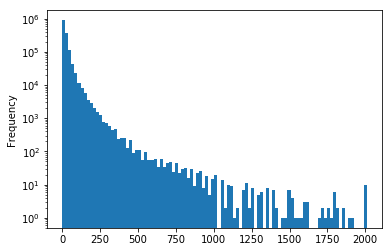

In [51]:
max_price=train['price'].max()
print max_price
min_price=train['price'].min()
print min_price
train['price'].plot(bins=100, kind='hist', log=True)

In [52]:
print len(train[(train['price']==0)])
train = train.drop(train[(train['price'] ==0)].index)

874


In [53]:
train_rows = train.shape[0]
print train_rows

1481661


In [54]:
#train= train[:5000]
merged_df = pd.concat([train, test], 0, ignore_index = True)

In [55]:
del train
del test

In [ ]:
merged_df["brand_name"]        = merged_df["brand_name"].fillna("Missing")
merged_df['category_name']     = merged_df['category_name'].fillna("Missing/Missing/Missing")
merged_df["item_description"]  = merged_df["item_description"].fillna("Missing")

In [ ]:
merged_df['Main_Category'], merged_df['Sub_Category1'], merged_df['Sub_Category2'] = zip(*merged_df['category_name'].apply(lambda x: x.split("/")))

In [ ]:
del [merged_df['category_name']]
merged_df.head()

In [ ]:
merged_df.isnull().sum()

In [ ]:
merged_df['Main_Category'] = merged_df['Main_Category'].astype('category')
merged_df['Sub_Category1'] = merged_df['Sub_Category1'].astype('category')
merged_df['Sub_Category2'] = merged_df['Sub_Category2'].astype('category')
#merged_df['item_condition_id'] = merged_df['item_condition_id'].astype('category') 
#merged_df['shipping'] = merged_df['shipping'].astype('category') 

In [ ]:
#X_item_condition_id = sparse.csr_matrix(pd.get_dummies(merged_df[["item_condition_id"]], sparse = True).values)
#X_shipping = sparse.csr_matrix(pd.get_dummies(train[["shipping"]], sparse = True).values)

In [ ]:
#wb_desc = wordbatch.WordBatch(None, extractor=(WordBag, {"hash_ngrams": 2, "hash_ngrams_weights": [1.0, 1.0],"hash_size": 2 ** 28, "norm": "l2", "tf": 1.0,"idf": None}), procs=8)
#wb_desc.dictionary_freeze = True
wb= wordbatch.WordBatch(extractor=(WordBag, {"hash_ngrams":2, "hash_ngrams_weights":[1.0, 1.0], "hash_size":2**28, "norm":'l2', "tf":1.0, "idf":None}))
wb.dictionary_freeze = True
X_desc = wb.fit_transform(merged_df['item_description'])

In [ ]:
# Word Count Vectorizer
count_vectorizer = CountVectorizer()
X_name = count_vectorizer.fit_transform(merged_df['name'])
X_main_Cat = count_vectorizer.fit_transform(merged_df['Main_Category'])
X_sub_Cat1 = count_vectorizer.fit_transform(merged_df['Sub_Category1'])
X_sub_Cat2 = count_vectorizer.fit_transform(merged_df['Sub_Category2'])

In [ ]:
cv_item_cond_ship = CountVectorizer(token_pattern=".+")
X_condition = cv_item_cond_ship.fit_transform((merged_df['item_condition_id'] + 10 * merged_df["shipping"]).apply(str))

In [ ]:
X = hstack((X_desc,X_name,X_sub_Cat1,X_main_Cat,X_sub_Cat2), dtype=np.float32).tocsr()

In [45]:
#X = joblib.load(filename)

In [57]:
X_train, X_test = X[:train_rows], X[train_rows:]
Y_train, Y_test = merged_df['price'][:train_rows], merged_df['price'][train_rows:]

In [ ]:
del merged_df
del X

Ridge Regression without CV

In [88]:
from sklearn.linear_model import Ridge
ridge_model_V2 = Ridge(alpha=.5, copy_X=True, fit_intercept=True, max_iter=100,normalize=False, random_state=101, solver='auto', tol=0.01)
ridge_model_V2.fit(X_train, Y_train)
Y_pred_ridge_train = ridge_model_V2.predict(X_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, random_state=101, solver='auto', tol=0.01)

In [ ]:
Y_pred_ridge_test = ridge_model_V2.predict(X_test)

Lasso without CV

In [91]:
lassoreg = Lasso(alpha=.01,copy_X=True, max_iter=400, normalize=False, random_state=101, tol=0.01)
lassoreg.fit(X_train,Y_train)
Y_pred_lasso_train= lassoreg.predict(X_train)

In [ ]:
Y_pred_lasso_test= lassoreg.predict(X_test)

Check the RMSE on Train data

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms_ridge = sqrt(mean_squared_error(Y_train, Y_pred_ridgecv_train))
rms_lasso = sqrt(mean_squared_error(Y_train, Y_pred_lassocv_train))
print rms_ridge
print rms_lasso

Ridge with Cross Validation

In [129]:
from sklearn.linear_model import RidgeCV
ridge_model_V3 =RidgeCV(alphas=(0.1, .5, 1), fit_intercept=True, normalize=False, scoring=None, cv=5, gcv_mode=None, store_cv_values=False)
ridge_model_V3.fit(X_train, Y_train)

RidgeCV(alphas=(0.1, 0.5, 1), cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [ ]:
Y_pred_ridgecv_test = ridge_model_V3.predict(X_test)

Lasso with CV

In [ ]:
lassocv = LassoCV(alphas=(0.1, .5, 1), cv=5, max_iter=100000, fit_intercept=True, normalize=False)
lassocv.fit(X_train, y_train)
Y_pred_lassocv_train= lassocv.predict(X_train)

In [ ]:
Y_pred_lassocv_test= lassocv.predict(X_test)

In [107]:
Y_pred_Ensemble = .3*Y_pred_ridgecv_test + 0.7*Y_pred_lassocv_test 
rms_ensemble = sqrt(mean_squared_error(Y_train, Y_pred_Ensemble))

In [151]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso
for Model in [Ridge, Lasso]:
    model = Model()
    print('%s: %s' % (Model.__name__,cross_val_score(model, X_train, Y_train).mean()))

Ridge: 0.398484683455953
Lasso: 0.003024045513219109


In [119]:
pd.DataFrame(Y_pred_Ensemble).to_csv('prediction.csv', index=False)